# Analyze SAE Training

This notebook analyzes the training results of the SAE model:
1. Visualize training metrics
2. Verify sparsity
3. Verify learning (weights are not uniform)

In [17]:
%load_ext autoreload
%autoreload 2

import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from amber.mechanistic.sae.modules.topk_sae import TopKSae
from amber.store.local_store import LocalStore
from amber.store.store_dataloader import StoreDataloader

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
STORE_DIR = Path("./store")
HISTORY_FILE = STORE_DIR / "runs" / "training_20251212_184640" / "history.json"
SAE_MODEL_PATH = STORE_DIR / "runs" / "training_20251212_184640" / "model.pt"

print(f"📁 Store directory: {STORE_DIR}")
print(f"📊 History file: {HISTORY_FILE}")
print(f"💾 SAE model: {SAE_MODEL_PATH}")

📁 Store directory: store
📊 History file: store/runs/training_20251212_184640/history.json
💾 SAE model: store/runs/training_20251212_184640/model.pt


In [23]:
with open(HISTORY_FILE, 'r') as f:
    history = json.load(f)

print("📊 Training history keys:", list(history.keys()))
print(f"📈 Number of epochs: {len(history['loss'])}")

📊 Training history keys: ['loss', 'recon_mse', 'l1', 'r2', 'l0', 'dead_features_pct']
📈 Number of epochs: 1


## 1. Visualize Training Metrics

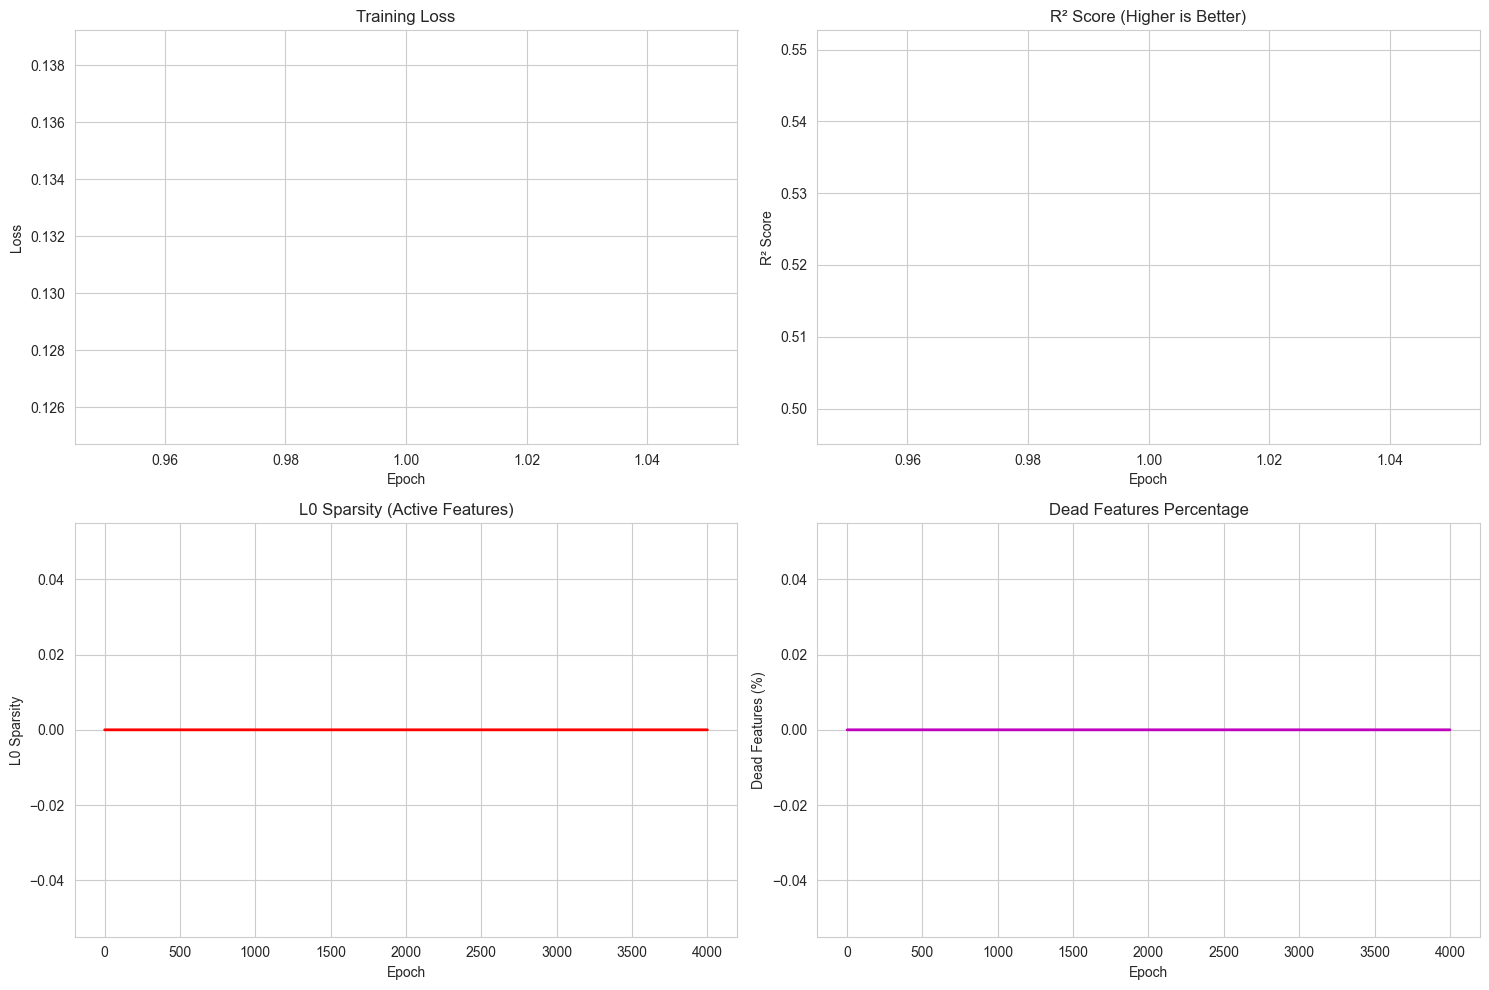

✅ Final metrics:
   Loss: 0.131961
   R²: 0.523852
   L0: 0.00
   Dead features: 0.00%


In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['loss']) + 1)

axes[0, 0].plot(epochs, history['loss'], 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].grid(True)

if history.get('r2'):
    axes[0, 1].plot(epochs, history['r2'], 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('R² Score (Higher is Better)')
    axes[0, 1].grid(True)

if history.get('l0'):
    l0_values = [x for x in history['l0'] if x is not None]
    l0_epochs = [i+1 for i, x in enumerate(history['l0']) if x is not None]
    if l0_values:
        axes[1, 0].plot(l0_epochs, l0_values, 'r-', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('L0 Sparsity')
        axes[1, 0].set_title('L0 Sparsity (Active Features)')
        axes[1, 0].grid(True)

if history.get('dead_features_pct'):
    dead_values = [x for x in history['dead_features_pct'] if x is not None]
    dead_epochs = [i+1 for i, x in enumerate(history['dead_features_pct']) if x is not None]
    if dead_values:
        axes[1, 1].plot(dead_epochs, dead_values, 'm-', linewidth=2)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Dead Features (%)')
        axes[1, 1].set_title('Dead Features Percentage')
        axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"✅ Final metrics:")
print(f"   Loss: {history['loss'][-1]:.6f}")
if history.get('r2'):
    print(f"   R²: {history['r2'][-1]:.6f}")
if history.get('l0'):
    final_l0 = [x for x in history['l0'] if x is not None]
    if final_l0:
        print(f"   L0: {final_l0[-1]:.2f}")
if history.get('dead_features_pct'):
    final_dead = [x for x in history['dead_features_pct'] if x is not None]
    if final_dead:
        print(f"   Dead features: {final_dead[-1]:.2f}%")

## 2. Load SAE Model

In [25]:
sae = TopKSae.load(SAE_MODEL_PATH)
print(f"✅ SAE loaded")
print(f"   Input dimension: {sae.context.n_inputs}")
print(f"   Latent dimension: {sae.context.n_latents}")
print(f"   TopK: {sae.k}")

2025-12-12 18:48:25,828 [INFO] amber.mechanistic.sae.modules.topk_sae: 
Loaded TopKSAE from store/runs/training_20251212_184640/model.pt
n_latents=6144, n_inputs=1536, k=8


✅ SAE loaded
   Input dimension: 1536
   Latent dimension: 6144
   TopK: 8


## 3. Verify Sparsity

In [29]:
store = LocalStore(base_path=STORE_DIR)
run_id_file = STORE_DIR / "run_id.txt"
with open(run_id_file, 'r') as f:
    RUN_ID = f.read().strip()

meta = store.get_run_metadata(RUN_ID)
layer_signature = meta.get('layer_signatures')[0]

print(f"📁 Run ID: {RUN_ID}")
print(f"🎯 Layer: {layer_signature}")

📁 Run ID: activations_20251212_172220
🎯 Layer: llamaforcausallm_model_layers_16_post_attention_layernorm


In [30]:
dataloader = StoreDataloader(
    store=store,
    run_id=RUN_ID,
    layer=layer_signature,
    key="activations",
    batch_size=256,
    max_batches=5
)

all_l0_values = []
all_latents = []

with torch.no_grad():
    for batch_idx, batch_activations in enumerate(dataloader):
        if isinstance(batch_activations, dict):
            activations = batch_activations.get("activations")
        elif isinstance(batch_activations, list):
            activations = batch_activations[0] if batch_activations else None
        else:
            activations = batch_activations
        
        if activations is None:
            continue
            
        if not isinstance(activations, torch.Tensor):
            continue
        
        latents = sae.encode(activations)
        all_latents.append(latents)
        
        l0_per_sample = (latents.abs() > 1e-6).sum(dim=-1).float()
        all_l0_values.extend(l0_per_sample.cpu().tolist())

all_latents_tensor = torch.cat(all_latents, dim=0)

print(f"✅ Processed {len(all_l0_values)} samples")
print(f"📊 Mean L0: {np.mean(all_l0_values):.2f}")
print(f"📊 Std L0: {np.std(all_l0_values):.2f}")
print(f"📊 Expected TopK: {sae.k}")

✅ Processed 1280 samples
📊 Mean L0: 8.00
📊 Std L0: 0.00
📊 Expected TopK: 8


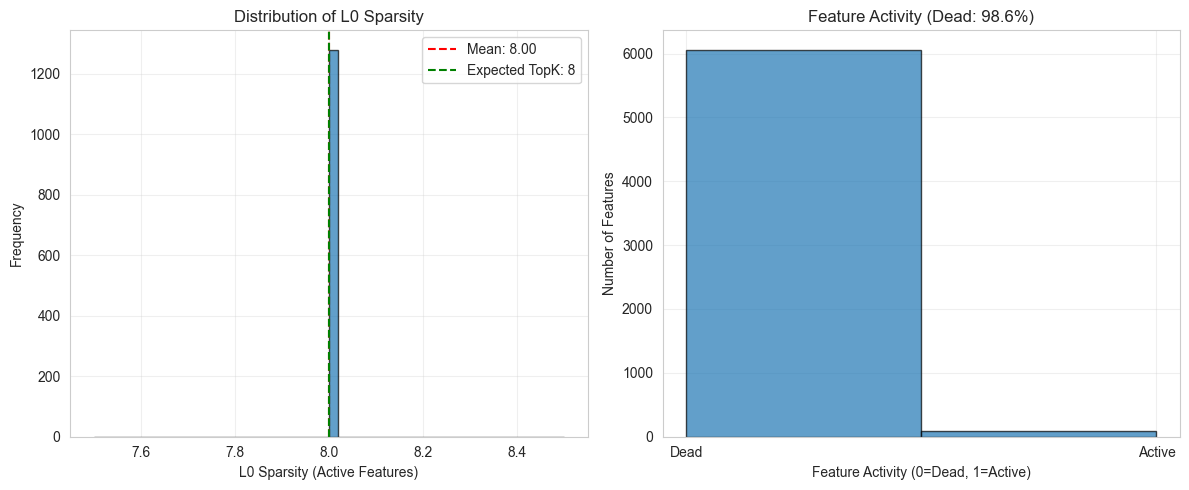

✅ Sparsity verification:
   Dead features: 6059 / 6144 (98.62%)
   Active features: 85 / 6144


In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_l0_values, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(all_l0_values), color='r', linestyle='--', label=f'Mean: {np.mean(all_l0_values):.2f}')
plt.axvline(sae.k, color='g', linestyle='--', label=f'Expected TopK: {sae.k}')
plt.xlabel('L0 Sparsity (Active Features)')
plt.ylabel('Frequency')
plt.title('Distribution of L0 Sparsity')
plt.legend()
plt.grid(True, alpha=0.3)

feature_activity = (all_latents_tensor.abs() > 1e-6).any(dim=0).float()
dead_features = (feature_activity == 0).sum().item()
dead_pct = dead_features / sae.context.n_latents * 100.0

plt.subplot(1, 2, 2)
feature_activity_counts = feature_activity.cpu().numpy()
plt.hist(feature_activity_counts, bins=2, edgecolor='black', alpha=0.7)
plt.xlabel('Feature Activity (0=Dead, 1=Active)')
plt.ylabel('Number of Features')
plt.title(f'Feature Activity (Dead: {dead_pct:.1f}%)')
plt.xticks([0, 1], ['Dead', 'Active'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Sparsity verification:")
print(f"   Dead features: {dead_features} / {sae.context.n_latents} ({dead_pct:.2f}%)")
print(f"   Active features: {sae.context.n_latents - dead_features} / {sae.context.n_latents}")

## 4. Verify Learning (Weights are not uniform)

In [32]:
state_dict = sae.sae_engine.state_dict()
print("🔍 SAE state dict keys:", list(state_dict.keys()))

🔍 SAE state dict keys: ['encoder.final_block.0.weight', 'encoder.final_block.0.bias', 'dictionary._weights', 'dictionary.multiplier']


## 5. Verify Reconstruction Quality

In [35]:
dataloader = StoreDataloader(
    store=store,
    run_id=RUN_ID,
    layer=layer_signature,
    key="activations",
    batch_size=256,
    max_batches=3
)

reconstruction_errors = []

with torch.no_grad():
    for batch_idx, batch_activations in enumerate(dataloader):
        if isinstance(batch_activations, dict):
            activations = batch_activations.get("activations")
        elif isinstance(batch_activations, list):
            activations = batch_activations[0] if batch_activations else None
        else:
            activations = batch_activations
        
        if activations is None or not isinstance(activations, torch.Tensor):
            continue
        
        reconstructed = sae.forward(activations)
        
        mse = ((reconstructed - activations) ** 2).mean(dim=-1)
        reconstruction_errors.extend(mse.cpu().tolist())

print(f"✅ Computed reconstruction error for {len(reconstruction_errors)} samples")
print(f"📊 Mean MSE: {np.mean(reconstruction_errors):.6f}")
print(f"📊 Std MSE: {np.std(reconstruction_errors):.6f}")
print(f"📊 Min MSE: {np.min(reconstruction_errors):.6f}")
print(f"📊 Max MSE: {np.max(reconstruction_errors):.6f}")

✅ Computed reconstruction error for 768 samples
📊 Mean MSE: 0.142349
📊 Std MSE: 0.042085
📊 Min MSE: 0.000120
📊 Max MSE: 0.284142


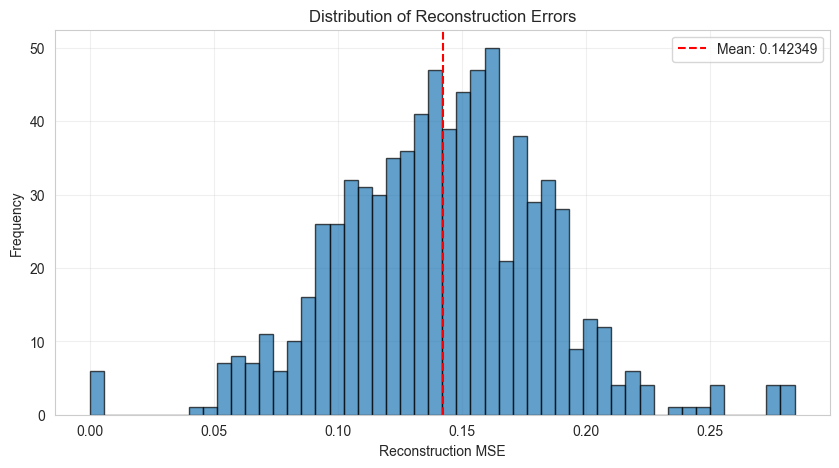


✅ Summary:
   SAE is sparse: L0 ≈ 8.00 (expected TopK=8)
   Dead features: 98.62%
   Reconstruction quality: Mean MSE=0.142349


In [37]:
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(reconstruction_errors), color='r', linestyle='--', 
            label=f'Mean: {np.mean(reconstruction_errors):.6f}')
plt.xlabel('Reconstruction MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ Summary:")
print(f"   SAE is sparse: L0 ≈ {np.mean(all_l0_values):.2f} (expected TopK={sae.k})")
print(f"   Dead features: {dead_pct:.2f}%")
print(f"   Reconstruction quality: Mean MSE={np.mean(reconstruction_errors):.6f}")